Materia: NLP - B52024

Desafío Nº3 - Notebook con arquetictura LSTM

Alumno: Fabricio Lopretto (a1616)


### Objetivo

- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias

- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.

### Resolviendo:

In [ ]:
# Importa las librerías necesarias
import random
import io
import pickle
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.utils import pad_sequences

### Datos
Como ejemplo se utilizará como corpus un dataset de cuentos de habla inglés. En particular, como corpus, se selecciona uno de los cuentos.

In [130]:
# Define la ruta al archivo de datos
ruta_notebook = os.getcwd()

# Ruta a un cuento en particular como corpus
ruta_archivo = ruta_notebook + '/datasets/THE SHADOW.txt'

In [131]:
# Lee el archivo completo como una cadena de texto
with open(ruta_archivo, 'r', encoding='utf-8') as file:
    texto = file.read()

# Divide el texto en oraciones usando el punto como delimitador
oraciones = texto.split('.')

# Crea un DataFrame con cada oración como un documento
df = pd.DataFrame(oraciones, columns=['documento'])

# Elimina posibles filas vacías que puedan haber quedado al dividir
df = df[df['documento'].str.strip() != '']

# Elimina saltos de línea al principio y al final de cada oración
df['documento'] = df['documento'].str.strip()

# Muestra el DataFrame
df.head()

,documento
0,"It is in the hot lands that the sun burns, sur..."
1,But now it was only to the HOT lands that a le...
2,"He, and all sensible folks, were obliged to st..."
3,"The narrow street with the high houses, was bu..."
4,The learned man from the cold lands he was a y...


Consideraremos que cada secuencia para este dataset es una oración del cuento.

Una de las primeras decisiones que hay que tomar es el tamaño de contexto de tokens máximo que puede consumir el modelo. Este podría ser un hiperparámetro del problema.

Para elegir el tamaño de contexto máximo para este problema se puede explorar el dataset, para ello:
- se consideran las palabras como términos.
- se segmentará el texto de todos los versos del dataset y ses explorará la cantidad de términos presentes.



In [132]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 212


### Elegir el tamaño del contexto

In [133]:
# Accede a la columna 'documento' y la convierte en una lista
text = list(df['documento'])

# Muestra la lista resultante
print(text)

['It is in the hot lands that the sun burns, sure enough! there the people become quite a mahogany brown, ay, and in the HOTTEST lands they are burnt to Negroes', 'But now it was only to the HOT lands that a learned man had come from the cold; there he thought that he could run about just as when at home, but he soon found out his mistake', 'He, and all sensible folks, were obliged to stay within doors the window-shutters and doors were closed the whole day; it looked as if the whole house slept, or there was no one at home', 'The narrow street with the high houses, was built so that the sunshine must fall there from morning till evening it was really not to be borne', 'The learned man from the cold lands he was a young man, and seemed to be a clever man sat in a glowing oven; it took effect on him, he became quite meagre even his shadow shrunk in, for the sun had also an effect on it', 'It was first towards evening when the sun was down, that they began to freshen up again', 'In the w

In [134]:
# Segmenta el texto con la utilidad de Keras en una lista de palabras para cada documento
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [135]:
# Muestra el primer elemento de la lista
text[0]

'It is in the hot lands that the sun burns, sure enough! there the people become quite a mahogany brown, ay, and in the HOTTEST lands they are burnt to Negroes'

In [136]:
# Muestra la lista de palabras del primer documento
segmented_sentences[0]

['it',
 'is',
 'in',
 'the',
 'hot',
 'lands',
 'that',
 'the',
 'sun',
 'burns',
 'sure',
 'enough',
 'there',
 'the',
 'people',
 'become',
 'quite',
 'a',
 'mahogany',
 'brown',
 'ay',
 'and',
 'in',
 'the',
 'hottest',
 'lands',
 'they',
 'are',
 'burnt',
 'to',
 'negroes']

In [137]:
# Calcula la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

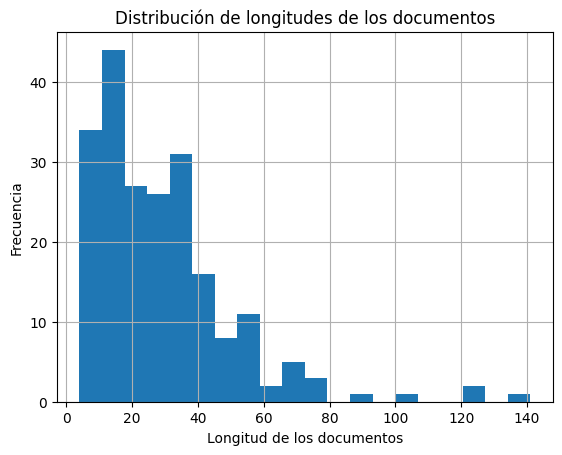

In [138]:
# Genera la distribución de longitudes de los documentos
plt.hist(length_sentences,bins=20)
plt.xlabel("Longitud de los documentos")
plt.ylabel("Frecuencia")
plt.title("Distribución de longitudes de los documentos")
plt.grid(True)
plt.show()

In [139]:
"""
A partir de la distribución de longitudes de secuencias se elige algún criterio
para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
otros criterios también pueden ser válidos (media o mediana) con la justificación adecuada.
También puede ser una selección "a mano".
"""

# Se utiliza el "-1" porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90)-1)

# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 53


###  Tokenizar

In [140]:
# Instancia el tokenizador
tok = Tokenizer()

"""
El tokenizer "aprende" las palabras que se usaran.
Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
fuera del vocabulario aprendido.
"""
tok.fit_on_texts(segmented_sentences)

# Convierte las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [141]:
# Visualiza los tokens de las palabras del vocabulario en el primer documento
tokenized_sentences[0]

[3,
 15,
 8,
 1,
 339,
 91,
 10,
 1,
 129,
 340,
 341,
 342,
 23,
 1,
 152,
 92,
 45,
 4,
 177,
 343,
 511,
 2,
 8,
 1,
 512,
 91,
 33,
 93,
 153,
 5,
 513]

In [142]:
# Muestra la lista de palabras del primer documento
segmented_sentences[0]

['it',
 'is',
 'in',
 'the',
 'hot',
 'lands',
 'that',
 'the',
 'sun',
 'burns',
 'sure',
 'enough',
 'there',
 'the',
 'people',
 'become',
 'quite',
 'a',
 'mahogany',
 'brown',
 'ay',
 'and',
 'in',
 'the',
 'hottest',
 'lands',
 'they',
 'are',
 'burnt',
 'to',
 'negroes']

### Organizando y estructurando el dataset

En este punto se tiene en la variable `tokenized_sentences` las oraciones del cuento tokenizadas. El algoritmo se quedara con un conjunto de validación que utilizara para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [143]:
# Divide las sentencias (palabras de lo documentos) tokenizadas en conjuntos de entrenamiento y validación
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

Subdivide las oraciones que tienen tamaño mayor al contexto máximo, para generar más secuencias de entrenamiento (este paso puede obviarse si el tamaño de contexto máximo es muy grande).

In [144]:
tok_sent = []

for sent in tokenized_sentences_train:

  """
  Si la secuencia tiene más términos que el tamaño de contexto máximo,
  arma varias sub-secuencias de tamaño máximo
  """
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [145]:
# Muestra la longitud de la lista de sub-secuencias
len(tok_sent)

546

Aumenta los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas:

In [146]:
tok_sent_augm = []

for sent in tok_sent:

  # Generas todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # Realiza el padding al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [147]:
# Concatena todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [148]:
# Muestra la dimensión del arreglo final
train_seqs.shape

(24390, 54)

In [149]:
"""
De este arreglo obtiene las entradas y los targets que
consumirá nuestro sistema en tiempo de entrenamiento.
"""
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

Se estructura el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

In [150]:
# Muestra la dimensión del objetivo
y.shape

(24390, 53)

In [151]:
# Muestra las palabras del vocabulario con su token
tok.index_word

{1: 'the',
 2: 'and',
 3: 'it',
 4: 'a',
 5: 'to',
 6: 'i',
 7: '”',
 8: 'in',
 9: 'was',
 10: 'that',
 11: 'he',
 12: 'of',
 13: 'shadow',
 14: 'you',
 15: 'is',
 16: 'so',
 17: 'she',
 18: 'said',
 19: 'with',
 20: 'man',
 21: 'but',
 22: 'as',
 23: 'there',
 24: 'had',
 25: 'not',
 26: 'one',
 27: 'for',
 28: 'be',
 29: 'have',
 30: 'on',
 31: 'her',
 32: 'me',
 33: 'they',
 34: 'learned',
 35: 'will',
 36: 'my',
 37: 'now',
 38: 'at',
 39: 'all',
 40: 'were',
 41: 'must',
 42: 'out',
 43: 'thou',
 44: 'no',
 45: 'quite',
 46: 'when',
 47: 'his',
 48: 'what',
 49: 'about',
 50: 'him',
 51: 'came',
 52: 'know',
 53: 'then',
 54: 'do',
 55: 'went',
 56: 'little',
 57: 'from',
 58: 'thought',
 59: 'could',
 60: 'if',
 61: 'like',
 62: '“i',
 63: 'go',
 64: 'would',
 65: 'say',
 66: 'princess',
 67: 'evening',
 68: 'which',
 69: 'who',
 70: 'this',
 71: 'more',
 72: 'up',
 73: 'well',
 74: '“it',
 75: 'always',
 76: 'shall',
 77: 'by',
 78: 'see',
 79: 'only',
 80: 'cold',
 81: 'down',


In [152]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

1250

In [153]:
"""
El índice para cada palabra
El sistema las ordena de las más populares a las menos populares
"""
print(tok.word_index)

{'the': 1, 'and': 2, 'it': 3, 'a': 4, 'to': 5, 'i': 6, '”': 7, 'in': 8, 'was': 9, 'that': 10, 'he': 11, 'of': 12, 'shadow': 13, 'you': 14, 'is': 15, 'so': 16, 'she': 17, 'said': 18, 'with': 19, 'man': 20, 'but': 21, 'as': 22, 'there': 23, 'had': 24, 'not': 25, 'one': 26, 'for': 27, 'be': 28, 'have': 29, 'on': 30, 'her': 31, 'me': 32, 'they': 33, 'learned': 34, 'will': 35, 'my': 36, 'now': 37, 'at': 38, 'all': 39, 'were': 40, 'must': 41, 'out': 42, 'thou': 43, 'no': 44, 'quite': 45, 'when': 46, 'his': 47, 'what': 48, 'about': 49, 'him': 50, 'came': 51, 'know': 52, 'then': 53, 'do': 54, 'went': 55, 'little': 56, 'from': 57, 'thought': 58, 'could': 59, 'if': 60, 'like': 61, '“i': 62, 'go': 63, 'would': 64, 'say': 65, 'princess': 66, 'evening': 67, 'which': 68, 'who': 69, 'this': 70, 'more': 71, 'up': 72, 'well': 73, '“it': 74, 'always': 75, 'shall': 76, 'by': 77, 'see': 78, 'only': 79, 'cold': 80, 'down': 81, 'again': 82, 'has': 83, 'balcony': 84, 'yes': 85, 'other': 86, 'everything': 87,

In [154]:
"""
Cantidad de veces quea aparece cada palabra en cada "documento"
(1 documento = 1 caso de entrada)
"""
print(tok.word_docs)

defaultdict(<class 'int'>, {'a': 85, 'that': 65, 'people': 6, 'in': 77, 'brown': 2, 'hottest': 1, 'burnt': 6, 'they': 23, 'ay': 1, 'sure': 2, 'mahogany': 5, 'are': 11, 'is': 44, 'enough': 2, 'lands': 10, 'it': 90, 'sun': 7, 'the': 171, 'negroes': 1, 'to': 86, 'hot': 2, 'there': 36, 'quite': 20, 'and': 119, 'become': 10, 'burns': 2, 'found': 4, 'now': 24, 'mistake': 1, 'when': 20, 'had': 34, 'only': 10, 'he': 45, 'cold': 12, 'at': 22, 'home': 10, 'from': 17, 'come': 7, 'man': 49, 'his': 18, 'soon': 3, 'thought': 17, 'but': 47, 'learned': 32, 'out': 21, 'as': 41, 'run': 1, 'about': 19, 'just': 11, 'was': 67, 'could': 15, 'within': 3, 'sensible': 1, 'shutters': 1, 'doors': 2, 'all': 23, 'or': 8, 'window': 3, 'day': 5, 'no': 19, 'slept': 2, 'were': 20, 'if': 16, 'one': 38, 'looked': 3, 'closed': 1, 'obliged': 3, 'whole': 9, 'house': 6, 'stay': 2, 'folks': 2, 'really': 10, 'houses': 2, 'till': 2, 'so': 46, 'narrow': 1, 'fall': 3, 'built': 1, 'high': 3, 'borne': 1, 'must': 20, 'not': 39, 'mo


### Definir el modelo

In [155]:
model = Sequential()

# La primera capa es de embedding entrenable (tamaño de los vectores: hiperparámetro)
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model.add(LSTM(100, return_sequences=True))
# model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=True))
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model.summary()

c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, None, 50)       │        62,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, None, 100)      │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, None, 100)      │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, None, 1251)     │       126,351 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,701 (1.26 MB)

 Trainable params: 329,701 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [156]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      """
      El callback inicializa con secuencias de validación sobre las cuales
      se mide la perplejidad y la paciencia para detener el entrenamiento.
      """
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # Se mueve en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # Arma todas las sub-secuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # Guarda la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # Recorre cada secuencia de validación
        for start,end in self.info:

          # Guarda las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # Calcula la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # Promedia todos los scores e imprime el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # Chequea si debe detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model_LSTM.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [157]:
"""
Realiza el entrenamiento, nótese el agregado del callback con su inicialización. El batch_size puede seleccionarse a mano
en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
"""
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=64)

Epoch 1/20
381/382 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 3.4609
 mean perplexity: 1046.5783563455623 

Saved new model!
382/382 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - loss: 3.4580
Epoch 2/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 2.5100
 mean perplexity: 1271.339042699484 

382/382 ━━━━━━━━━━━━━━━━━━━━ 36s 94ms/step - loss: 2.5096
Epoch 3/20
381/382 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 2.0358
 mean perplexity: 1508.4414463980816 

382/382 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - loss: 2.0353
Epoch 4/20
381/382 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.6139
 mean perplexity: 1920.4504282359399 

382/382 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - loss: 1.6134
Epoch 5/20
381/382 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 1.2496
 mean perplexity: 2145.316967920877 

382/382 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 1.2492
Epoch 6/20
381/382 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.9697
 mean perplexity: 2681.203776453885 

Stopping training...
382/382 ━━━━━━━━━━━━━━━━━━━━ 38s 

c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


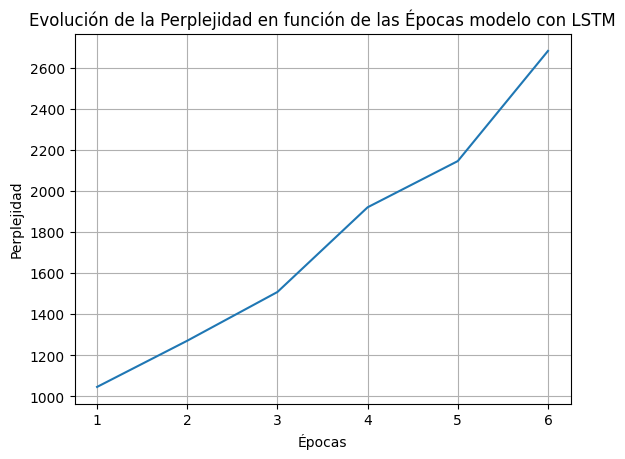

In [158]:
# Grafica la evolución de la perplejidad en función de las épocas.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.xlabel("Épocas")
plt.ylabel("Perplejidad")
plt.title("Evolución de la Perplejidad en función de las Épocas modelo con LSTM")
plt.grid(True)
plt.show()

In [159]:
# Carga el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model_LSTM.keras')


### Predicción de próxima palabra

In [160]:
# Instalación de  gradio
!pip install -q gradio


[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [161]:
# Importa gradio
import gradio as gr

def model_response(human_text):

    # Encodea
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tiene distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])

    # Busca en el vocabulario la palabra que corresopnde al indice (y_hat) predicho por el modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrega la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


### Generación de secuencias

In [162]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words, greedy_search=False):
    """
    Genera una secuencia de palabras con el modelo entrenado usando "Greedy Search".
    
    Args:
        model (keras.Model): Modelo entrenado.
        tokenizer (keras.Tokenizer): Tokenizer utilizado en el preprocesamiento.
        seed_text (str): Texto de entrada inicial.
        max_length (int): Longitud máxima de la secuencia de entrada.
        n_words (int): Número de palabras a agregar a la secuencia de entrada.
        greedy_search (bool): Si es True, usa "Greedy Search", de lo contrario usa el método con probabilidad.

    Returns:
        output_text (str): Texto generado con las "n_words" agregadas.
    """
    output_text = seed_text
    for _ in range(n_words):
        # Tokeniza el texto de entrada
        encoded = tokenizer.texts_to_sequences([output_text])[0]

        # Si tiene distinto largo, realiza padding
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

        # Predicción softmax
        preds = model.predict(encoded)[0, -1, :]

        if greedy_search:
            # Si es Greedy Search, selecciona la palabra más probable
            y_hat = np.argmax(preds)
        else:
            # Si no es Greedy Search, elige la palabra con la probabilidad más alta
            y_hat = np.argmax(preds)

        # Busca la palabra en el vocabulario
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

        # Agrega la palabra al texto generado
        output_text += ' ' + out_word

    return output_text


In [163]:
input_text='The learned man from the cold lands'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


'The learned man from the cold lands and and the and and the and and the and'

###  Beam search y muestreo aleatorio

In [164]:
# Funcionalidades para encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [165]:
# Importa la activación
from scipy.special import softmax

# Función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # Colecta todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # Criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # Traduce a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # Devuelve el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # Primera iteración

    # encode
    encoded = encode(input)

    # Primera predicción
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # Otiene el tamaño del vocabulario
    vocab_size = y_hat.shape[0]

    # Inicializa el historial
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # Selecciona un número de candidatos
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # Bucle beam search
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # Actualiza secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # Predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [166]:
"""
Predicción con beam search.
Se pueden camiar los modos entre 'det' (determinista) y
'sto' (estocástico)
para el caso estocástico también se puede variar la temperatura
"""
num_beams=10
salidas = beam_search(model,num_beams,num_words=6,input="The learned man from the cold lands",temp=1,mode='sto')

In [167]:
# Tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(10, 59)

In [168]:
# Muestra las salidas
for i in range(num_beams):
    print(decode(salidas[i]))


['the learned man from the cold lands and they had one in called']
['the learned man from the cold lands and they had colder hast on']
['the learned man from the cold lands and they had one so one']
['the learned man from the cold lands and they had one in one']
['the learned man from the cold lands and they had one to been']
['the learned man from the cold lands and they had one to the']
['the learned man from the cold lands and they had one in and']
['the learned man from the cold lands and they had one in say']
['the learned man from the cold lands and they had one so he']
['the learned man from the cold lands and they had one to with']


Experimento I: Se buscan nuevamente resultados, pero modificando la tempratura a valores 2, 10 y 100:

In [169]:
# Define el ancho de consideración
num_beams=10

# Realiza la llamada a la función que describe la técnica
salidas = beam_search(model,num_beams,num_words=6,input="The learned man from the cold lands",temp=2,mode='sto')

# Muestra las salidas
for i in range(num_beams):
    print(decode(salidas[i]))

['the learned man from the cold lands she not wise she be maiden']
['the learned man from the cold lands she not wise she but longer']
['the learned man from the cold lands she not wise she but should']
['the learned man from the cold lands she not wise she but charming']
['the learned man from the cold lands she not wise i get sort']
['the learned man from the cold lands she not wise i get mild']
["the learned man from the cold lands she not wise she didn't was"]
['the learned man from the cold lands she not wise she but walked']
['the learned man from the cold lands she not wise she be him']
['the learned man from the cold lands she not wise she but they']


In [170]:
# Define el ancho de consideración
num_beams=10

# Realiza la llamada a la función que describe la técnica
salidas = beam_search(model,num_beams,num_words=6,input="The learned man from the cold lands",temp=10,mode='sto')

# Muestra las salidas
for i in range(num_beams):
    print(decode(salidas[i]))

['the learned man from the cold lands composed shop pounds bid coffee cracks']
['the learned man from the cold lands composed i servant vanish being gems']
['the learned man from the cold lands would useful diamond around could unwell']
['the learned man from the cold lands whistled slippers tree sort father glittered']
['the learned man from the cold lands composed shop pounds bid says dance']
["the learned man from the cold lands composed shop pounds accepted seeing year's"]
['the learned man from the cold lands composed i servant vanish being ground']
['the learned man from the cold lands composed i influence astonished annoyed astonished']
['the learned man from the cold lands whistled slippers tree necessary within former']
['the learned man from the cold lands whistled slippers tree sort father window']


In [171]:
# Define el ancho de consideración
num_beams=10

# Realiza la llamada a la función que describe la técnica
salidas = beam_search(model,num_beams,num_words=6,input="The learned man from the cold lands",temp=100,mode='sto')

# Muestra las salidas
for i in range(num_beams):
    print(decode(salidas[i]))

['the learned man from the cold lands much accepted health “but extraordinary windows']
['the learned man from the cold lands much furthest pierced known dish nail']
['the learned man from the cold lands much furthest pierced known fell trimmed']
['the learned man from the cold lands much furthest pierced known case here']
['the learned man from the cold lands much accepted health with place could']
['the learned man from the cold lands much accepted health “but respect finely']
['the learned man from the cold lands much accepted health servants “tell saw']
['the learned man from the cold lands much accepted health “but extraordinary fresh']
['the learned man from the cold lands much furthest pierced known fell together']
['the learned man from the cold lands much furthest pierced known case thus']


Experimento II: Se buscan nuevamente resultados, pero modificando la técnica a determinista:

In [ ]:
# Define el ancho de consideración
num_beams=1

# Realiza la llamada a la función que describe la técnica
salidas = beam_search(model,num_beams,num_words=1,input="The learned man from the cold lands",temp=1,mode='det')

# Muestra las salidas
for i in range(num_beams):
    print(decode(salidas[i]))

['the learned man from the cold lands and']


Experimento III: Búsqueda de resultados con la técnica Greedy Search:

In [176]:
# Genera e imprime texto usando Greedy Search
salida = generate_seq(model, tok, seed_text="The learned man from the cold lands", max_length=max_context_size, n_words=1, greedy_search=True)
print(salida)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
The learned man from the cold lands and
